In [69]:
import pandas as pd
import os
import matplotlib as plt
import seaborn as sns
import numpy as np
import math

In [70]:
def eucDistance(dataframe, KM):
    # Get cluster centroids
    centroids = KM.cluster_centers_
    
    # Initialize an empty list to store distances
    distances = []
    
    # Calculate Euclidean distance for each data point
    for index, row in dataframe.iterrows():
        currCentroid = centroids[int(row['Kmeans Label'])]
        valCord = row.drop('Kmeans Label').values
        dist = math.dist(currCentroid, valCord)
        distances.append(dist)
    
    return distances

In [71]:
j = 0 # current file in the 2004 folder
data = pd.DataFrame()
    
for i in range(2004, 2010):
    df_flux_html = pd.read_html(f'https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-flux-en.php?year={i}')
    df_flux_html = df_flux_html[0]
    df_flux_html['Time'] = pd.to_timedelta(df_flux_html['Time'])
    df_flux_html['Time'] = df_flux_html['Time'] + pd.Timedelta(seconds=3)
    
    # sorting year folder to prevent skipping values
    yearFolder = os.listdir(str(i))
    yearFolder.sort()

    for file in yearFolder: # iterates through the folders found in each category(each category is the name of a folder in the 'predictEDSS' folder
        filename = f"{df_flux_html['Date'].apply(lambda date: date.replace('-', ''))[j]}CONT.MAG.csv"
        if filename == file:
            fileDataPerDay = pd.read_csv(os.path.join(str(i), filename), header = 5)
            fileDataPerDay['time(hh:mi:ss)'] = pd.to_timedelta(fileDataPerDay['time(hh:mi:ss)'])
            data = data.append(df_flux_html.join(fileDataPerDay, lsuffix = 'Time', rsuffix = 'time(hh:mi:ss)'))
            j += 1

In [ ]:
# Machine Learning part

In [72]:
# dropping cuz we don't need it cuh, puro 956
data.drop(data.columns[[0,1, 7, 8, 12]], axis = 1, inplace = True)

KMeans(n_clusters=4)

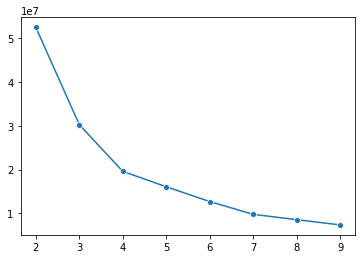

In [73]:
from sklearn.cluster import KMeans

# Test to determine best # of clusters: 4
scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(data)
    scores.append(kmeans.inertia_)
#data['Kmeans Label'] = kmeans.labels_
sns.lineplot(x = range(2,10), y = scores, marker = 'o')

kmeans = KMeans(n_clusters = 4)
kmeans.fit(data)

In [74]:
data['Kmeans Label'] = kmeans.labels_

In [75]:
data['Euclid distance'] = eucDistance(data, kmeans)

In [76]:
from sklearn.ensemble import IsolationForest
isoForest = IsolationForest(n_estimators = 100, contamination = 0.0007)
isoForest.fit(data)
isoForest_score = isoForest.predict(data)
data['isoForest Anomaly'] = isoForest_score

In [77]:
predicted_Geostorms = data[data['isoForest Anomaly'] == -1]

In [78]:
predicted_Geostorms.head()

,Julian day,Carringtonrotation,Observed Flux,Adjusted Flux,URSI Flux,X,Y,Z,Kmeans Label,Euclid distance,isoForest Anomaly
748,2453623.337,2034.195,707.6,717.6,645.8,8104.150,3671.450,59437.898,1,1041.142907,-1
752,2453624.462,2034.236,629.8,638.3,574.5,8101.225,3673.425,59436.352,1,909.378486,-1
1010,2454076.337,2050.803,573.4,556.6,500.9,8115.826,3657.014,59421.927,0,810.881649,-1
